In [16]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, Conv2D, BatchNormalization, Reshape, UpSampling2D, Flatten, LeakyReLU, Input
from tensorflow.keras.models import Sequential, Model
import numpy as np
import matplotlib.pyplot as plt

# 생성자 모델 생성

In [6]:
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2))) # 128은 임의로 정한 노드의 수 / 7*7은 이미지의 최초 크기
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D()) # 이미지의 가로, 세로 크기를 2배씩 늘려줌
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

# 판별자 모델 생성

In [8]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

# 생성자와 판별자 모델 연결시키는 gan 모델 생성

In [12]:
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_3 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


## 신경망 실행시키는 함수 만들기

In [19]:
def gan_train(epoch, batch_size, saving_interval):
    (x_train, _), (_, _) = mnist.load_data()
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
    x_train = (x_train-127.5) / 127.5

    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for i in range(epoch):
        # 실제 데이터를 판별자에 입력하는 부분
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)

        # 가상 이미지를 판별자에 입력하는 부분
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

        # 판별자와 생성자의 오차 계산
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)

        print('epoch:%d' % i, 'd_loss:%.4f' % d_loss, 'g_loss:%.4f' % g_loss)

        if i % saving_interval == 0:
            #r, c = 5, 5
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)

            # Rescale images 0 - 1
            gen_imgs = 0.5 * gen_imgs + 0.5

            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5):
                  for k in range(5):
                        axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                        axs[j, k].axis('off')
                        count += 1
            fig.savefig('./datasets/gan_images/gan_mnist_%d.png'%i) # 2000번 반복되고, 배치 사이즈는 32,  200번마다 결과가 저장
        

1/1 [==============================] - 0s 35ms/step
epoch:0 d_loss:0.5583 g_loss:0.2693
1/1 [==============================] - 0s 34ms/step
epoch:1 d_loss:0.4975 g_loss:0.1942
1/1 [==============================] - 0s 31ms/step
epoch:2 d_loss:0.4916 g_loss:0.2090
1/1 [==============================] - 0s 33ms/step
epoch:3 d_loss:0.5020 g_loss:0.2811
1/1 [==============================] - 0s 32ms/step
epoch:4 d_loss:0.4955 g_loss:0.4370
1/1 [==============================] - 0s 31ms/step
epoch:5 d_loss:0.5029 g_loss:0.5596
1/1 [==============================] - 0s 30ms/step
epoch:6 d_loss:0.5730 g_loss:0.6718
1/1 [==============================] - 0s 33ms/step
epoch:7 d_loss:0.6545 g_loss:0.5170
1/1 [==============================] - 0s 31ms/step
epoch:8 d_loss:0.5935 g_loss:0.5138
1/1 [==============================] - 0s 34ms/step
epoch:9 d_loss:0.6174 g_loss:0.5697
1/1 [==============================] - 0s 36ms/step
epoch:10 d_loss:0.5645 g_loss:0.5370
1/1 [==========================

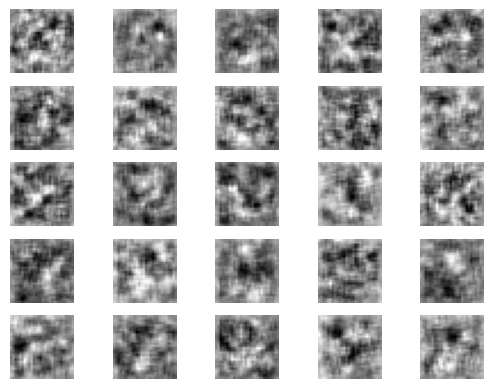

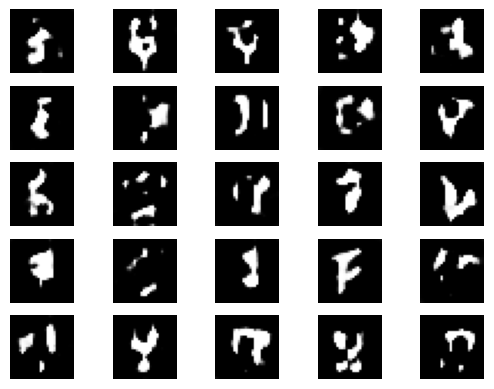

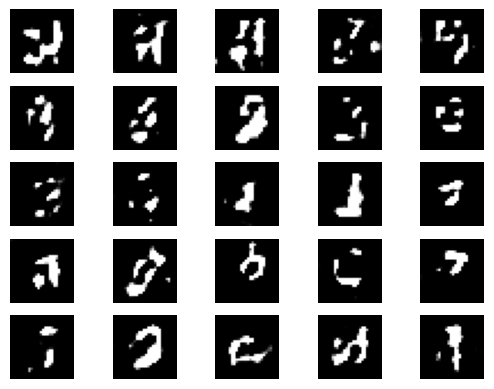

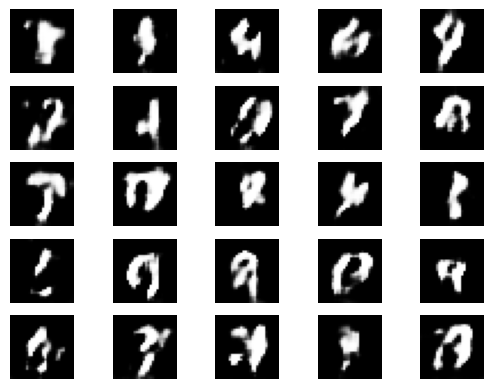

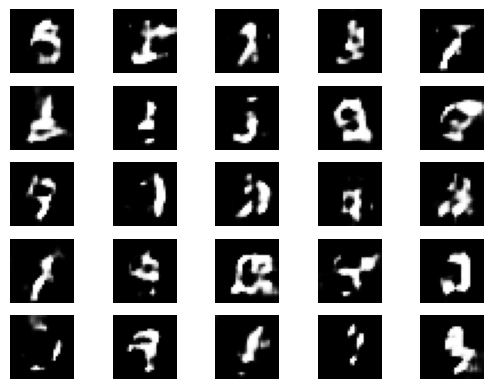

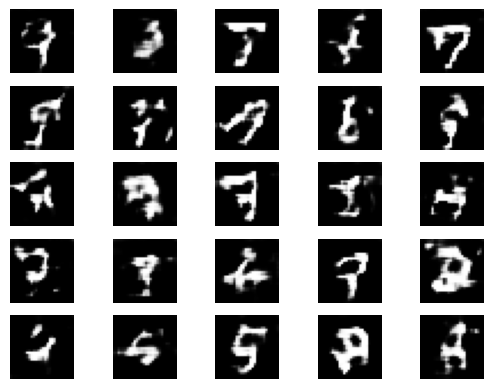

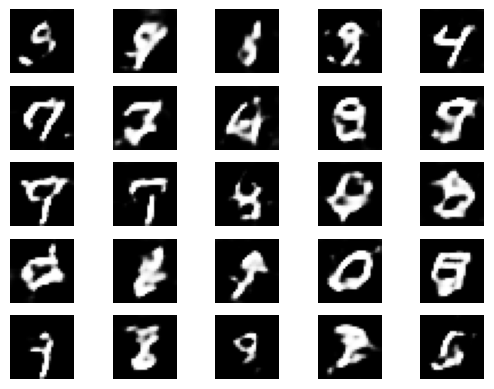

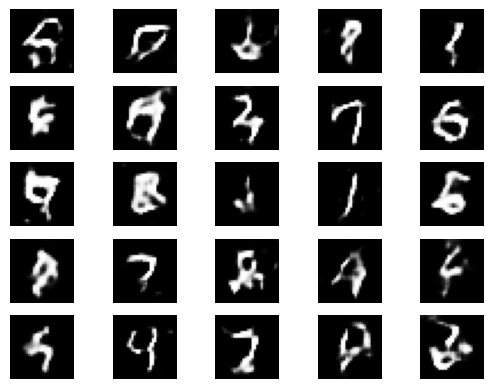

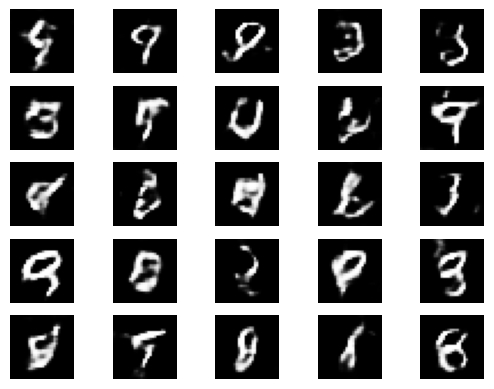

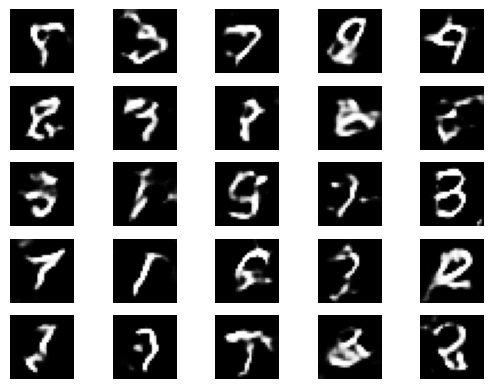

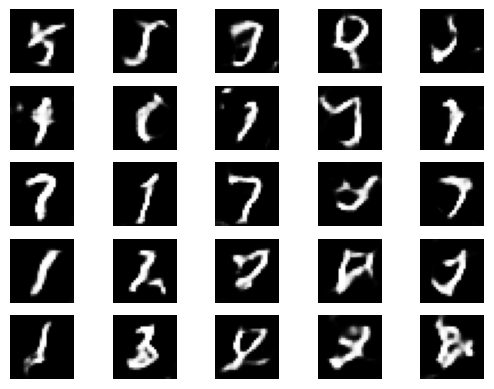

In [20]:
gan_train(2001, 32, 200)